In [ ]:
###############################################################################
# The Institute for the Design of Advanced Energy Systems Integrated Platform
# Framework (IDAES IP) was produced under the DOE Institute for the
# Design of Advanced Energy Systems (IDAES).
#
# Copyright (c) 2018-2023 by the software owners: The Regents of the
# University of California, through Lawrence Berkeley National Laboratory,
# National Technology & Engineering Solutions of Sandia, LLC, Carnegie Mellon
# University, West Virginia University Research Corporation, et al.
# All rights reserved.  Please see the files COPYRIGHT.md and LICENSE.md
# for full copyright and license information.
###############################################################################

# Supercritical CO2 Property Surrogate with PySMO Surrogate Object - flowsheet_optimization (Part 3)


Maintainer: Javal Vyas

Author: Javal Vyas

Updated: 2024-01-24


With the surrogate model being embedded in the property package, it is ready to be used in the flowsheet. We start by creating the following flowsheet using the IDAES package. 

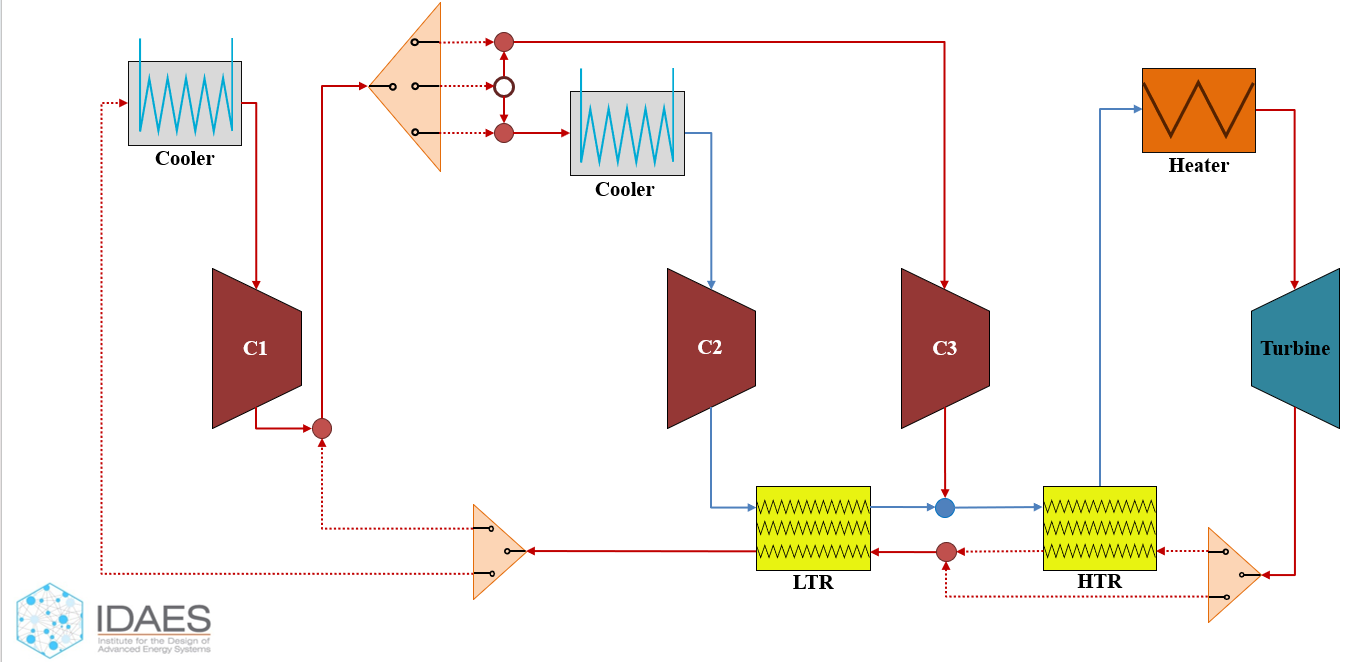

In [1]:
from IPython.display import Image
from pathlib import Path


def datafile_path(name):
    return Path("..") / name


Image(datafile_path("CO2_flowsheet.png"))

# 1. Importing libraries

We will be using the unit models from the `IDAES` package along with components from `pyomo.environ` and `pyomo.network`. 

In [2]:
from pyomo.environ import (
    ConcreteModel,
    Block,
    Var,
    Param,
    Constraint,
    SolverFactory,
    TransformationFactory,
    TerminationCondition,
    value,
    Expression,
    minimize,
    units,
)
from pyomo.network import Arc, SequentialDecomposition

# Import IDAES libraries
from idaes.core import FlowsheetBlock, UnitModelBlockData
from idaes.models.unit_models import (
    Mixer,
    MomentumMixingType,
    PressureChanger,
    Heater,
    Separator,
    HeatExchanger,
)
from idaes.models.unit_models.pressure_changer import ThermodynamicAssumption
from idaes.core.util.model_statistics import degrees_of_freedom
from idaes.core.util.initialization import propagate_state
from properties import SCO2ParameterBlock

import idaes.logger as idaeslog

_log = idaeslog.getModelLogger("my_model", level=idaeslog.DEBUG, tag="model")

# 2. Constructing the flowsheet

To construct the flowsheet we need to define a ConcreteModel using pyomo and then add a FlowsheetBlock to the ConcreteModel. Here since we are focusing on the steady state process, we shall have the dynamic flag as False in the FlowsheetBlock. Next, we define the properties in the FlowsheetBlock that we imported from the properties.py file. Then start adding the unit models to the FlowsheetBlock with the suitable arguments, after which we connect them using Arcs as in the flowsheet above. 

Once we have the connected flowsheet, we initialize individual unit models. Before initializing, we fix desired variables for the desired behavior of the unit model and then use `propagate_state` to pass on the state variables to next unit model in the flowsheet. After completely initializing the flowsheet, we convert the network to a mathematical form by using `network.expand_arcs` from the TransformationFactory and apply it on the flowsheet block. Then we call the solver and solve the flowsheet to calculate the total work in the process. 

In [3]:
def main():
    # Setup solver and options
    solver = SolverFactory("ipopt")
    outlvl = 0
    tee = True

    # Set up concrete model
    m = ConcreteModel()

    # Create a flowsheet block
    m.fs = FlowsheetBlock(dynamic=False)

    # Create the properties param block
    m.fs.properties = SCO2ParameterBlock()

    # Add unit models to the flowsheet
    m.fs.boiler = Heater(
        dynamic=False, property_package=m.fs.properties, has_pressure_change=True
    )

    m.fs.turbine = PressureChanger(
        dynamic=False,
        property_package=m.fs.properties,
        compressor=False,
        thermodynamic_assumption=ThermodynamicAssumption.isentropic,
    )

    m.fs.HTR_pseudo_shell = Heater(
        dynamic=False, property_package=m.fs.properties, has_pressure_change=True
    )

    m.fs.HTR_pseudo_tube = Heater(
        dynamic=False, property_package=m.fs.properties, has_pressure_change=True
    )

    m.fs.LTR_pseudo_shell = Heater(
        dynamic=False, property_package=m.fs.properties, has_pressure_change=True
    )

    m.fs.LTR_pseudo_tube = Heater(
        dynamic=False, property_package=m.fs.properties, has_pressure_change=True
    )

    m.fs.splitter_1 = Separator(
        property_package=m.fs.properties, outlet_list=["bypass", "to_cooler"]
    )

    m.fs.co2_cooler = Heater(
        dynamic=False, property_package=m.fs.properties, has_pressure_change=True
    )

    m.fs.main_compressor = PressureChanger(
        dynamic=False,
        property_package=m.fs.properties,
        compressor=True,
        thermodynamic_assumption=ThermodynamicAssumption.isentropic,
    )

    m.fs.bypass_compressor = PressureChanger(
        dynamic=False,
        property_package=m.fs.properties,
        compressor=True,
        thermodynamic_assumption=ThermodynamicAssumption.isentropic,
    )

    m.fs.splitter_2 = Separator(
        property_package=m.fs.properties,
        ideal_separation=False,
        outlet_list=["to_FG_cooler", "to_LTR"],
    )

    m.fs.FG_cooler = Heater(
        dynamic=False, property_package=m.fs.properties, has_pressure_change=True
    )

    m.fs.mixer = Mixer(
        property_package=m.fs.properties, inlet_list=["FG_out", "LTR_out", "bypass"]
    )

    # # Connect the flowsheet
    m.fs.s01 = Arc(source=m.fs.boiler.outlet, destination=m.fs.turbine.inlet)
    m.fs.s02 = Arc(source=m.fs.turbine.outlet, destination=m.fs.HTR_pseudo_shell.inlet)
    m.fs.s03 = Arc(
        source=m.fs.HTR_pseudo_shell.outlet, destination=m.fs.LTR_pseudo_shell.inlet
    )
    m.fs.s04 = Arc(
        source=m.fs.LTR_pseudo_shell.outlet, destination=m.fs.splitter_1.inlet
    )
    m.fs.s05 = Arc(source=m.fs.splitter_1.to_cooler, destination=m.fs.co2_cooler.inlet)
    m.fs.s06 = Arc(
        source=m.fs.splitter_1.bypass, destination=m.fs.bypass_compressor.inlet
    )
    m.fs.s07 = Arc(
        source=m.fs.co2_cooler.outlet, destination=m.fs.main_compressor.inlet
    )
    m.fs.s08 = Arc(source=m.fs.bypass_compressor.outlet, destination=m.fs.mixer.bypass)
    m.fs.s09 = Arc(
        source=m.fs.main_compressor.outlet, destination=m.fs.splitter_2.inlet
    )
    m.fs.s10 = Arc(
        source=m.fs.splitter_2.to_FG_cooler, destination=m.fs.FG_cooler.inlet
    )
    m.fs.s11 = Arc(
        source=m.fs.splitter_2.to_LTR, destination=m.fs.LTR_pseudo_tube.inlet
    )
    m.fs.s12 = Arc(source=m.fs.LTR_pseudo_tube.outlet, destination=m.fs.mixer.LTR_out)
    m.fs.s13 = Arc(source=m.fs.FG_cooler.outlet, destination=m.fs.mixer.FG_out)
    m.fs.s14 = Arc(source=m.fs.mixer.outlet, destination=m.fs.HTR_pseudo_tube.inlet)

    # NETL Baseline
    m.fs.boiler.inlet.flow_mol.fix(121.1)
    m.fs.boiler.inlet.temperature.fix(685.15)
    m.fs.boiler.inlet.pressure.fix(34.51)

    m.fs.boiler.outlet.temperature.fix(893.15)  # Turbine inlet T = 620 C
    m.fs.boiler.deltaP.fix(-0.21)

    m.fs.boiler.initialize(outlvl=outlvl)

    propagate_state(m.fs.s01)

    m.fs.turbine.ratioP.fix(1 / 3.68)
    m.fs.turbine.efficiency_isentropic.fix(0.927)
    m.fs.turbine.initialize(outlvl=outlvl)

    propagate_state(m.fs.s02)
    m.fs.HTR_pseudo_shell.outlet.temperature.fix(489.15)
    m.fs.HTR_pseudo_shell.deltaP.fix(-0.07)

    m.fs.HTR_pseudo_shell.initialize(outlvl=outlvl)

    propagate_state(m.fs.s03)

    m.fs.LTR_pseudo_shell.outlet.temperature.fix(354.15)
    m.fs.LTR_pseudo_shell.deltaP.fix(-0.07)
    m.fs.LTR_pseudo_shell.initialize(outlvl=outlvl)

    propagate_state(m.fs.s04)
    m.fs.splitter_1.split_fraction[0, "bypass"].fix(0.25)

    m.fs.splitter_1.initialize(outlvl=outlvl)

    propagate_state(m.fs.s05)
    m.fs.co2_cooler.outlet.temperature.fix(308.15)
    m.fs.co2_cooler.deltaP.fix(-0.07)
    m.fs.co2_cooler.initialize(outlvl=outlvl)

    propagate_state(m.fs.s06)
    m.fs.bypass_compressor.efficiency_isentropic.fix(0.85)
    m.fs.bypass_compressor.ratioP.fix(3.8)
    m.fs.bypass_compressor.initialize(outlvl=outlvl)

    propagate_state(m.fs.s07)
    m.fs.main_compressor.efficiency_isentropic.fix(0.85)
    m.fs.main_compressor.ratioP.fix(3.8)
    m.fs.main_compressor.initialize(outlvl=outlvl)

    propagate_state(m.fs.s09)

    m.fs.splitter_2.split_fraction[0, "to_FG_cooler"].fix(0.046)
    m.fs.splitter_2.initialize(outlvl=outlvl)

    propagate_state(m.fs.s10)
    m.fs.FG_cooler.outlet.temperature.fix(483.15)
    m.fs.FG_cooler.deltaP.fix(-0.06)
    m.fs.FG_cooler.initialize(outlvl=outlvl)

    propagate_state(m.fs.s11)

    m.fs.LTR_pseudo_tube.deltaP.fix(0)
    m.fs.LTR_pseudo_tube.heat_duty[0].fix(-value(m.fs.LTR_pseudo_shell.heat_duty[0]))
    m.fs.LTR_pseudo_tube.initialize(outlvl=outlvl)

    # Add constraint heats of the LTR_pseudo shell and tube
    m.fs.LTR_pseudo_tube.heat_duty[0].unfix()
    m.fs.c1 = Constraint(
        expr=m.fs.LTR_pseudo_shell.heat_duty[0] == -m.fs.LTR_pseudo_tube.heat_duty[0]
    )

    propagate_state(m.fs.s08)
    propagate_state(m.fs.s12)
    propagate_state(m.fs.s13)

    m.fs.mixer.initialize(outlvl=outlvl)

    propagate_state(m.fs.s14)

    m.fs.HTR_pseudo_tube.heat_duty[0].fix(-value(m.fs.HTR_pseudo_shell.heat_duty[0]))
    m.fs.HTR_pseudo_tube.deltaP.fix(-0.07)
    m.fs.HTR_pseudo_tube.initialize(outlvl=outlvl)

    m.fs.HTR_pseudo_tube.heat_duty[0].unfix()
    m.fs.c2 = Constraint(
        expr=m.fs.HTR_pseudo_shell.heat_duty[0] == -m.fs.HTR_pseudo_tube.heat_duty[0]
    )

    TransformationFactory("network.expand_arcs").apply_to(m.fs)

    print("--------------------------------------------------------------------")
    print("The degrees of freedom for the flowsheet is ", degrees_of_freedom(m))
    print("--------------------------------------------------------------------")

    solver.solve(m, tee=tee)

    #
    from idaes.core.util.units_of_measurement import (
        convert_quantity_to_reporting_units,
        report_quantity,
    )

    # Print reports
    for i in m.fs.component_objects(Block):
        if isinstance(i, UnitModelBlockData):
            i.report()

    # Converting units for readability
    print(
        -1 * value(units.convert(m.fs.turbine.work_mechanical[0], units.kW))
        - 1 * value(units.convert(m.fs.main_compressor.work_mechanical[0], units.kW))
        - 1 * value(units.convert(m.fs.bypass_compressor.work_mechanical[0], units.kW)),
        units.kW,
    )
    return m


if __name__ == "__main__":
    m = main()

2023-08-19 23:45:27 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=poly

===========================Polynomial Regression===============================================


The number of cross-validation cases (3) is used.
The default training/cross-validation split of 0.75 is used.
No iterations will be run.
Default parameter estimation method is used.
Parameter estimation method:  pyomo 


===========================Polynomial Regression===============================================


The number of cross-validation cases (3) is used.
The default training/cross-validation split of 0.75 is used.
No iterations will be run.
Default parameter estimation method is used.
Parameter estimation method:  pyomo 

2023-08-19 23:45:27 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=poly

===========================Polynomial Regression===============================================


The number of cross-validation cases (3) is used.
The default training/cros